# Sonification

In [107]:
import numpy as np
import pandas as pd
import os
import wave
import IPython.display as ipd # plays a file within notebook
import glob
from scipy.io import wavfile

import random 
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn')

In [108]:
train_list = pd.read_csv('data/train.csv')
np.unique(train_list.label)

array(['Acoustic_guitar', 'Applause', 'Bark', 'Bass_drum',
       'Burping_or_eructation', 'Bus', 'Cello', 'Chime', 'Clarinet',
       'Computer_keyboard', 'Cough', 'Cowbell', 'Double_bass',
       'Drawer_open_or_close', 'Electric_piano', 'Fart',
       'Finger_snapping', 'Fireworks', 'Flute', 'Glockenspiel', 'Gong',
       'Gunshot_or_gunfire', 'Harmonica', 'Hi-hat', 'Keys_jangling',
       'Knock', 'Laughter', 'Meow', 'Microwave_oven', 'Oboe', 'Saxophone',
       'Scissors', 'Shatter', 'Snare_drum', 'Squeak', 'Tambourine',
       'Tearing', 'Telephone', 'Trumpet', 'Violin_or_fiddle', 'Writing'],
      dtype=object)

## 1. Retrive audio wave

In [109]:
# get all hi-hat samples
rnd = random.choice(np.where(train_list.label == 'Hi-hat')[0])
rnd_file = train_list.fname[rnd]
#file = os.path.join('data/audio_train/', rnd_file)
#ipd.Audio(file)

In [110]:
file = 'sample_audios/f40e1c0b.wav'
ipd.Audio(file)

In [111]:
import librosa, librosa.display

In [112]:
x, sr = librosa.load(file)
print('sample rate:', sr)

sample rate: 22050


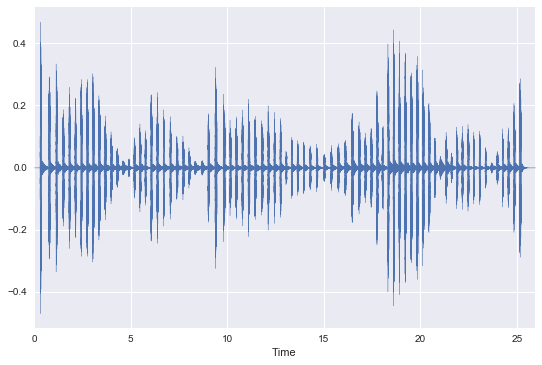

In [113]:
# display the wave form 
librosa.display.waveplot(x, sr=sr)

## 2. Onset detection

In [114]:
# Compute the Short term fourier transform
onset_frames = librosa.onset.onset_detect(x, sr=sr)
print('Onset frames:',onset_frames)

onset_times = librosa.frames_to_time(onset_frames, sr=sr)
print('Onset times:', onset_times)

Onset frames: [  13   32   49   64   78   91  104  117  130  143  157  171  184  198
  211  222  235  248  260  274  288  303  317  331  345  359  373  388
  403  422  436  449  463  477  492  507  521  535  548  562  573  587
  600  614  629  645  661  677  692  708  723  737  750  763  776  788
  801  813  826  839  852  866  879  892  905  918  930  941  954  966
  979  992 1006 1019 1032 1044 1056 1069 1082]
Onset times: [ 0.30185941  0.74303855  1.13777778  1.4860771   1.81115646  2.11301587
  2.41487528  2.71673469  3.0185941   3.32045351  3.64553288  3.97061224
  4.27247166  4.59755102  4.89941043  5.15482993  5.45668934  5.75854875
  6.03718821  6.36226757  6.68734694  7.03564626  7.36072562  7.68580499
  8.01088435  8.33596372  8.66104308  9.0093424   9.35764172  9.79882086
 10.12390023 10.42575964 10.750839   11.07591837 11.42421769 11.77251701
 12.09759637 12.42267574 12.72453515 13.04961451 13.30503401 13.63011338
 13.93197279 14.25705215 14.60535147 14.97687075 15.34839002

Convert onset waves into sample indices

In [115]:
onset_samples = librosa.frames_to_samples(onset_frames)
print('onset_samples:', onset_samples)

onset_samples: [  6656  16384  25088  32768  39936  46592  53248  59904  66560  73216
  80384  87552  94208 101376 108032 113664 120320 126976 133120 140288
 147456 155136 162304 169472 176640 183808 190976 198656 206336 216064
 223232 229888 237056 244224 251904 259584 266752 273920 280576 287744
 293376 300544 307200 314368 322048 330240 338432 346624 354304 362496
 370176 377344 384000 390656 397312 403456 410112 416256 422912 429568
 436224 443392 450048 456704 463360 470016 476160 481792 488448 494592
 501248 507904 515072 521728 528384 534528 540672 547328 553984]


In [116]:
# Use the `length` parameter so the click track is the same length as the original signal
clicks = librosa.clicks(times=onset_times, length=len(x))
clicks

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [117]:
# Play the click track "added to" the original signal
ipd.Audio(x+clicks, rate=sr)

## 3. Segment Audio

Save into an array, segments, 100-ms segments beginning at each onset.

In [118]:
frame_sz = int(0.100*sr)
segments = np.array([x[i:i+frame_sz] for i in onset_samples])

In [119]:
# A function that adds 300 ms of silence onto the end of each segment and concatenates them into one signal.

def concatenate_segments(segments, sr=22050, pad_time=0.300):
    padded_segments = [np.concatenate([segment, np.zeros(int(pad_time*sr))]) for segment in segments]
    return np.concatenate(padded_segments)

In [120]:
# listen to the new signal
concatenated_signal = concatenate_segments(segments, sr)
ipd.Audio(concatenated_signal, rate=sr)

## 4. Extract features

In [121]:
zcrs = [sum(librosa.core.zero_crossings(segment)) for segment in segments]
print(zcrs)

ind = np.argsort(zcrs)
print(ind)

[1330, 1367, 1322, 1360, 1329, 1360, 1353, 1384, 1417, 1379, 1395, 1412, 1396, 1326, 1441, 1406, 1388, 1440, 1403, 1393, 1402, 1381, 1421, 1424, 1406, 1387, 1409, 1460, 1475, 1450, 1408, 1384, 1416, 1372, 1372, 1388, 1337, 1359, 1347, 1399, 1360, 1396, 1378, 1411, 1414, 1386, 1374, 1378, 1344, 1385, 1427, 1475, 1455, 1388, 1477, 1376, 1389, 1401, 1408, 1429, 1430, 1406, 1407, 1351, 1330, 1354, 1476, 1449, 1451, 1480, 1455, 1502, 1451, 1381, 1389, 1373, 1432, 1399, 1432]
[ 2 13  4  0 64 36 48 38 63  6 65 37 40  5  3  1 34 33 75 46 55 47 42  9
 21 73  7 31 49 45 25 16 35 53 74 56 19 10 12 41 39 77 57 20 18 15 24 61
 62 30 58 26 43 11 44 32  8 22 23 50 59 60 78 76 17 14 67 29 68 72 52 70
 27 51 28 66 54 69 71]


In [122]:
# Sort the segments by zero crossing rate, and concatenate the sorted segments.

concatenated_signal = concatenate_segments(segments[ind], sr)

# listen to the sorted signals
ipd.Audio(concatenated_signal, rate=sr)